#### <b>Load Required Libraries</b>

In [2]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [4]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Image Visualization</b>

In [5]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [6]:
# show torch.Tensor image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # [3, H, W]
    image = transforms.ToPILImage()(image)
    # show an image whose values are between [0, 1]
    plt.imshow(image)
    plt.show()

#### <b>Load Pre-trained Classification Model</b>

In [7]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EcpGMF03mR9Ko1MM-kMSmloB4ceabuYCvnHaGZPgLNMzrA?download=1 -O cifar10_model.pth

--2022-09-29 14:54:28--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EcpGMF03mR9Ko1MM-kMSmloB4ceabuYCvnHaGZPgLNMzrA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/Pytorch%20Adversarial%20Training%20on%20CIFAR-10/Pre-trained/basic_training?ga=1 [following]
--2022-09-29 14:54:28--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/Pytorch%20Adversarial%20Training%20on%20CIFAR-10/Pre-trained/basic_training?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 44755840 (43M) [application/octet-stream]
Saving to: ‘cifar10_model.pth’

cifar10_model.pth   100%[========

In [9]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [10]:
model = ResNet18()
model = model.to(device)
model = torch.nn.DataParallel(model)
checkpoint = torch.load('./cifar10_model.pth')
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

#### <b>Load Test Dataset</b>

In [11]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified


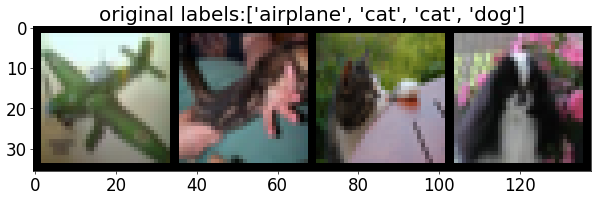

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: airplane (0)
Image #2: cat (3)
Image #3: cat (3)
Image #4: dog (5)


In [12]:
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(test_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([class_names[x] for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, label in enumerate(classes[:4]):
    print(f'Image #{i + 1}: {class_names[label]} ({label})')

#### <b>Test Phase</b>

[Prediction Result Examples]


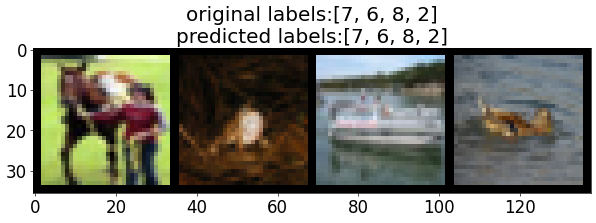

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: horse (7)
Image #1: frog (6)
Image #1: ship (8)
Image #1: bird (2)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: horse (7)
Image #1: frog (6)
Image #1: ship (8)
Image #1: bird (2)


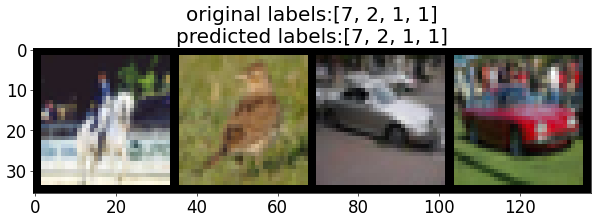

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: horse (7)
Image #1: bird (2)
Image #1: automobile (1)
Image #1: automobile (1)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: horse (7)
Image #1: bird (2)
Image #1: automobile (1)
Image #1: automobile (1)
[Validation] Loss: 0.0031 Accuracy: 95.2800% Time elapsed: 3.8052s (total 10000 images)


In [37]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            
    
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            
            
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[:4]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[:4]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            
            
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[4:8]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[4:8]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')


    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [14]:
!pip install foolbox
!pip install advertorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 0.25

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


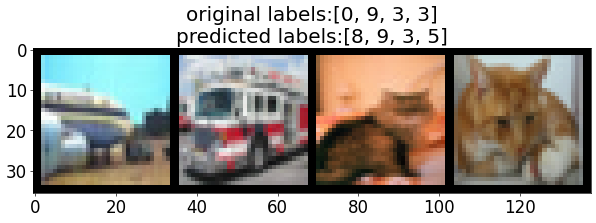

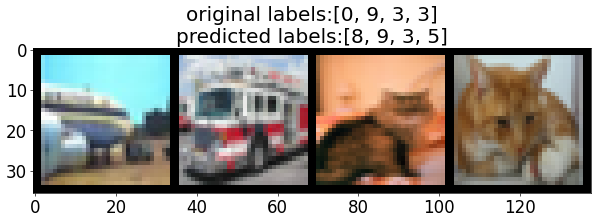

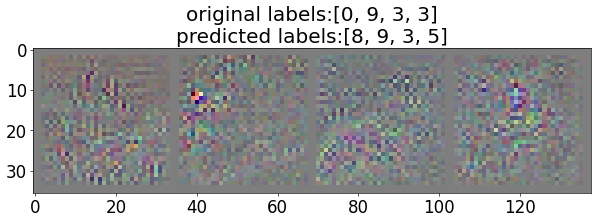

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: airplane (0)
Image #1: truck (9)
Image #1: cat (3)
Image #1: cat (3)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ship (8)
Image #1: truck (9)
Image #1: cat (3)
Image #1: dog (5)


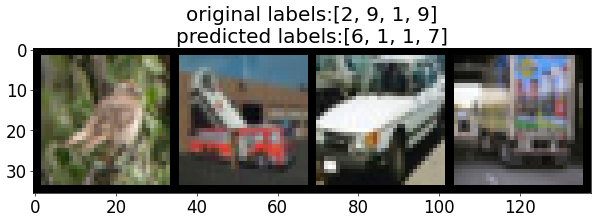

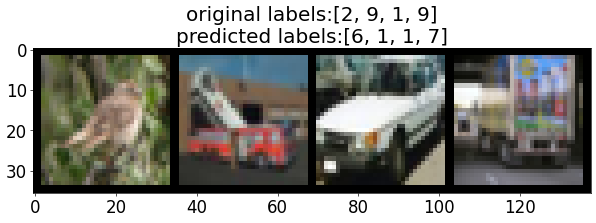

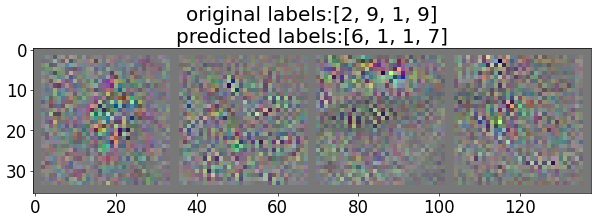

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: truck (9)
Image #1: automobile (1)
Image #1: truck (9)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: automobile (1)
Image #1: automobile (1)
Image #1: horse (7)
[Step #0] Loss: 0.1151 Accuracy: 32.8125% Time elapsed: 1.4881s (total 64 images)
[Step #10] Loss: 0.1137 Accuracy: 33.2386% Time elapsed: 5.3759s (total 704 images)
[Step #20] Loss: 0.1158 Accuracy: 32.1429% Time elapsed: 9.2896s (total 1344 images)
[Step #30] Loss: 0.1138 Accuracy: 32.8629% Time elapsed: 13.2090s (total 1984 images)
[Step #40] Loss: 0.1136 Accuracy: 32.5838% Time elapsed: 17.1265s (total 2624 images)
[Step #50] Loss: 0.1154 Accuracy: 31.7708% Time elapsed: 21.0648s (total 3264 images)
[Step #60] Loss: 0.1156 Accuracy: 31.5830% Time elapsed: 25.0042s (total 3904 images)
[Step #70] Loss: 0.1148 Accuracy: 32.0202% Time elapsed: 28.9573s (total 4544 images)
[Step #80] Loss: 0.1148 Accuracy: 31.8673% Time elapsed: 32.9

In [48]:
import time
import advertorch
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=0.25, nb_iter=7, eps_iter=0.25/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        
        clean = torchvision.utils.make_grid(inputs[:4])
        imshow_batch(clean.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        diff_img = images - clean
        diff_img -= diff_img.min()
        diff_img /= diff_img.max()
        imshow_batch(diff_img.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        
        
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        
        
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        clean = torchvision.utils.make_grid(inputs[4:8])
        imshow_batch(clean.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        diff_img = images - clean
        diff_img -= diff_img.min()
        diff_img /= diff_img.max()
        imshow_batch(diff_img.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 0.5

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


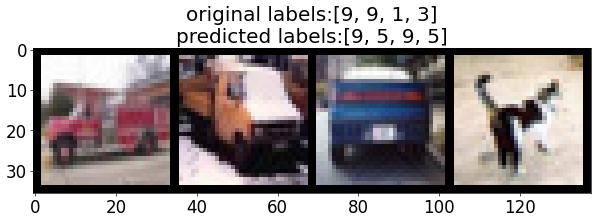

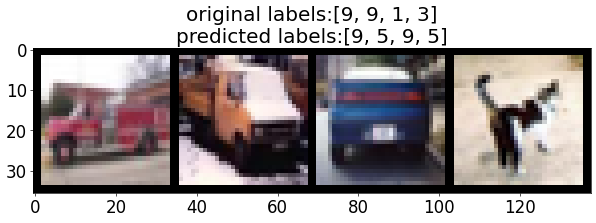

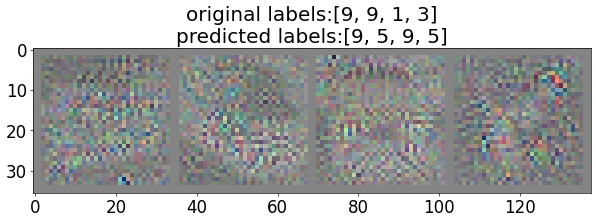

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: truck (9)
Image #1: truck (9)
Image #1: automobile (1)
Image #1: cat (3)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: truck (9)
Image #1: dog (5)
Image #1: truck (9)
Image #1: dog (5)


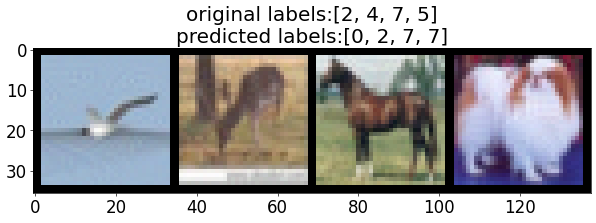

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: deer (4)
Image #1: horse (7)
Image #1: dog (5)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: airplane (0)
Image #1: bird (2)
Image #1: horse (7)
Image #1: horse (7)
[Step #0] Loss: 0.1882 Accuracy: 9.3750% Time elapsed: 1.2040s (total 64 images)
[Step #10] Loss: 0.1825 Accuracy: 14.4886% Time elapsed: 5.2725s (total 704 images)
[Step #20] Loss: 0.1859 Accuracy: 14.1369% Time elapsed: 9.3423s (total 1344 images)
[Step #30] Loss: 0.1891 Accuracy: 13.4577% Time elapsed: 13.4047s (total 1984 images)
[Step #40] Loss: 0.1895 Accuracy: 13.5671% Time elapsed: 17.4770s (total 2624 images)
[Step #50] Loss: 0.1901 Accuracy: 13.5723% Time elapsed: 21.5599s (total 3264 images)
[Step #60] Loss: 0.1891 Accuracy: 13.7295% Time elapsed: 25.6425s (total 3904 images)
[Step #70] Loss: 0.1897 Accuracy: 13.7544% Time elapsed: 29.7309s (total 4544 images)
[Step #80] Loss: 0.1898 Accuracy: 13.8310% Time elapsed: 33.8211s (total 5184

In [46]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=0.5, nb_iter=7, eps_iter=0.5/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        clean = torchvision.utils.make_grid(inputs[:4])
        imshow_batch(clean.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        diff_img = images - clean
        diff_img -= diff_img.min()
        diff_img /= diff_img.max()
        imshow_batch(diff_img.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        
        
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 1.0

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


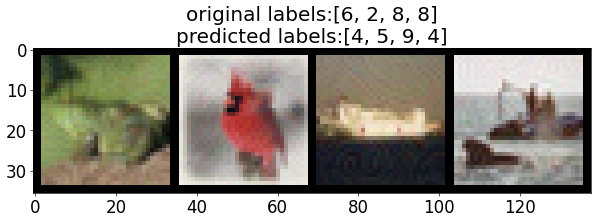

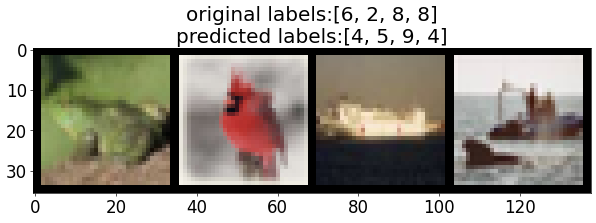

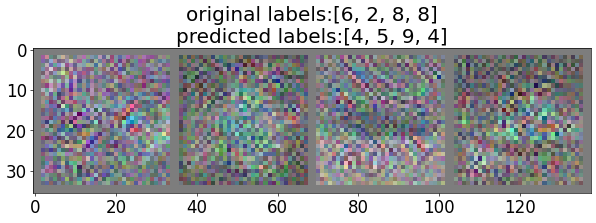

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: bird (2)
Image #1: ship (8)
Image #1: ship (8)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: deer (4)
Image #1: dog (5)
Image #1: truck (9)
Image #1: deer (4)


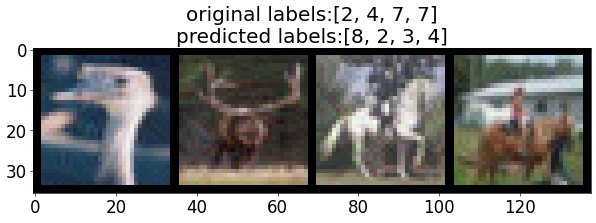

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: deer (4)
Image #1: horse (7)
Image #1: horse (7)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ship (8)
Image #1: bird (2)
Image #1: cat (3)
Image #1: deer (4)
[Step #0] Loss: 0.2507 Accuracy: 3.1250% Time elapsed: 1.1200s (total 64 images)
[Step #10] Loss: 0.2502 Accuracy: 2.9830% Time elapsed: 5.1610s (total 704 images)
[Step #20] Loss: 0.2526 Accuracy: 2.9018% Time elapsed: 9.1983s (total 1344 images)
[Step #30] Loss: 0.2516 Accuracy: 2.5706% Time elapsed: 13.2383s (total 1984 images)
[Step #40] Loss: 0.2535 Accuracy: 2.4390% Time elapsed: 17.2911s (total 2624 images)
[Step #50] Loss: 0.2548 Accuracy: 2.5735% Time elapsed: 21.3344s (total 3264 images)
[Step #60] Loss: 0.2548 Accuracy: 2.7408% Time elapsed: 25.3900s (total 3904 images)
[Step #70] Loss: 0.2556 Accuracy: 2.7289% Time elapsed: 29.4547s (total 4544 images)
[Step #80] Loss: 0.2555 Accuracy: 2.6235% Time elapsed: 33.5167s (total 5184 images)
[Ste

In [51]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=1.0, nb_iter=7, eps_iter=1.0/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        
        clean = torchvision.utils.make_grid(inputs[:4])
        imshow_batch(clean.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        diff_img = images - clean
        diff_img -= diff_img.min()
        diff_img /= diff_img.max()
        imshow_batch(diff_img.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        
        
        
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 4</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 2.0

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


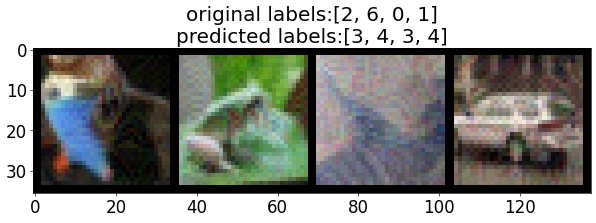

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: frog (6)
Image #1: airplane (0)
Image #1: automobile (1)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: cat (3)
Image #1: deer (4)
Image #1: cat (3)
Image #1: deer (4)


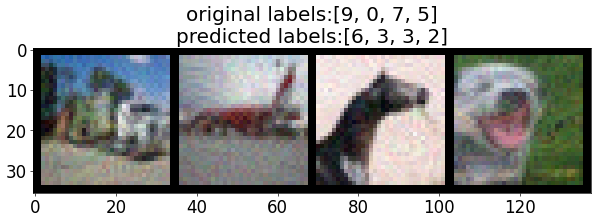

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: truck (9)
Image #1: airplane (0)
Image #1: horse (7)
Image #1: dog (5)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: cat (3)
Image #1: cat (3)
Image #1: bird (2)
[Step #0] Loss: 0.3037 Accuracy: 0.0000% Time elapsed: 1.3878s (total 64 images)
[Step #10] Loss: 0.2904 Accuracy: 0.4261% Time elapsed: 10.5662s (total 704 images)
[Step #20] Loss: 0.2929 Accuracy: 0.2976% Time elapsed: 19.7257s (total 1344 images)
[Step #30] Loss: 0.2935 Accuracy: 0.2016% Time elapsed: 28.8916s (total 1984 images)
[Step #40] Loss: 0.2934 Accuracy: 0.1905% Time elapsed: 38.0490s (total 2624 images)
[Step #50] Loss: 0.2943 Accuracy: 0.1532% Time elapsed: 47.2091s (total 3264 images)
[Step #60] Loss: 0.2943 Accuracy: 0.1281% Time elapsed: 56.3810s (total 3904 images)
[Step #70] Loss: 0.2939 Accuracy: 0.1540% Time elapsed: 65.5627s (total 4544 images)
[Step #80] Loss: 0.2944 Accuracy: 0.1543% Time elapsed: 74.7165s (total 5184 images)


In [ ]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=2.0, nb_iter=7, eps_iter=2.0/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 5</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 4.0

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


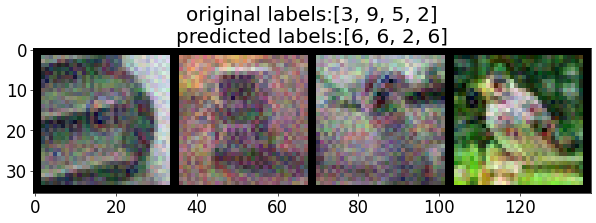

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: cat (3)
Image #1: truck (9)
Image #1: dog (5)
Image #1: bird (2)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: frog (6)
Image #1: bird (2)
Image #1: frog (6)


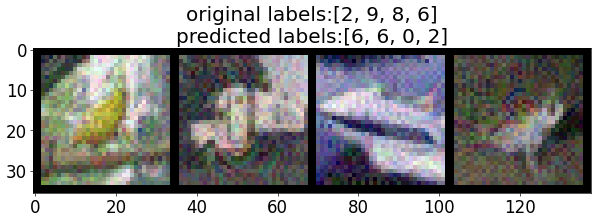

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: truck (9)
Image #1: ship (8)
Image #1: frog (6)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: frog (6)
Image #1: airplane (0)
Image #1: bird (2)
[Step #0] Loss: 0.3209 Accuracy: 0.0000% Time elapsed: 1.3817s (total 64 images)
[Step #10] Loss: 0.3153 Accuracy: 0.0000% Time elapsed: 10.5423s (total 704 images)
[Step #20] Loss: 0.3151 Accuracy: 0.0000% Time elapsed: 19.6805s (total 1344 images)
[Step #30] Loss: 0.3151 Accuracy: 0.0000% Time elapsed: 28.8367s (total 1984 images)
[Step #40] Loss: 0.3161 Accuracy: 0.0000% Time elapsed: 37.9886s (total 2624 images)
[Step #50] Loss: 0.3160 Accuracy: 0.0000% Time elapsed: 47.1268s (total 3264 images)
[Step #60] Loss: 0.3166 Accuracy: 0.0000% Time elapsed: 56.2744s (total 3904 images)
[Step #70] Loss: 0.3169 Accuracy: 0.0000% Time elapsed: 65.4168s (total 4544 images)
[Step #80] Loss: 0.3167 Accuracy: 0.0000% Time elapsed: 74.5498s (total 5184 images

In [ ]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=4.0, nb_iter=7, eps_iter=4.0/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 6</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 8.0

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


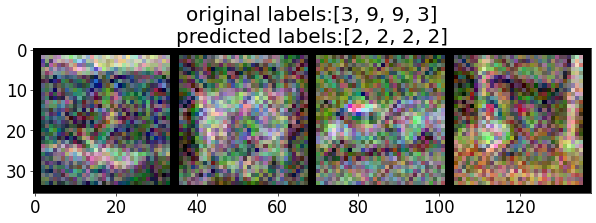

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: cat (3)
Image #1: truck (9)
Image #1: truck (9)
Image #1: cat (3)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: bird (2)
Image #1: bird (2)
Image #1: bird (2)


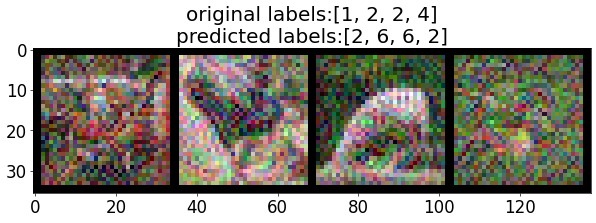

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: bird (2)
Image #1: bird (2)
Image #1: deer (4)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: frog (6)
Image #1: frog (6)
Image #1: bird (2)
[Step #0] Loss: 0.3411 Accuracy: 0.0000% Time elapsed: 1.3995s (total 64 images)
[Step #10] Loss: 0.3505 Accuracy: 0.0000% Time elapsed: 10.5462s (total 704 images)
[Step #20] Loss: 0.3514 Accuracy: 0.0000% Time elapsed: 19.6924s (total 1344 images)
[Step #30] Loss: 0.3518 Accuracy: 0.0000% Time elapsed: 28.8266s (total 1984 images)
[Step #40] Loss: 0.3523 Accuracy: 0.0000% Time elapsed: 37.9887s (total 2624 images)
[Step #50] Loss: 0.3516 Accuracy: 0.0000% Time elapsed: 47.1559s (total 3264 images)
[Step #60] Loss: 0.3518 Accuracy: 0.0000% Time elapsed: 56.3199s (total 3904 images)
[Step #70] Loss: 0.3516 Accuracy: 0.0000% Time elapsed: 65.4758s (total 4544 images)
[Step #80] Loss: 0.3519 Accuracy: 0.0000% Time elapsed: 74.6359s (total 5184 image

In [ ]:
import time
from advertorch.attacks import L2PGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=8.0, nb_iter=7, eps_iter=8.0/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Comparison with Foolbox</b>

* <b>Attack method</b>: 7-step L2 PGD
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 0.25

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


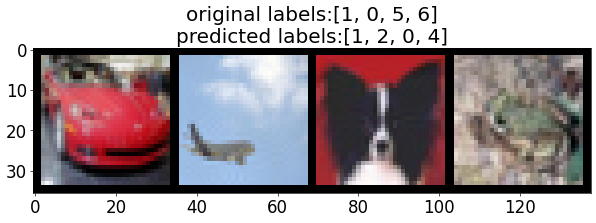

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: airplane (0)
Image #1: dog (5)
Image #1: frog (6)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: bird (2)
Image #1: airplane (0)
Image #1: deer (4)


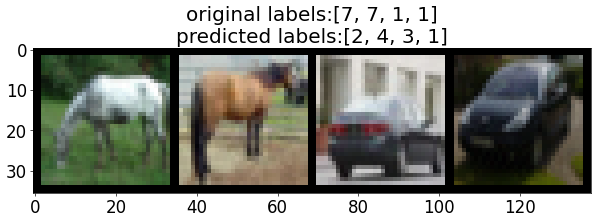

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: horse (7)
Image #1: horse (7)
Image #1: automobile (1)
Image #1: automobile (1)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: deer (4)
Image #1: cat (3)
Image #1: automobile (1)
[Step #0] Loss: 0.1061 Accuracy: 34.3750% Time elapsed: 1.5646s (total 64 images)
[Step #10] Loss: 0.1224 Accuracy: 28.2670% Time elapsed: 10.9528s (total 704 images)
[Step #20] Loss: 0.1175 Accuracy: 29.7619% Time elapsed: 20.3596s (total 1344 images)
[Step #30] Loss: 0.1171 Accuracy: 30.6452% Time elapsed: 29.8077s (total 1984 images)
[Step #40] Loss: 0.1180 Accuracy: 30.3735% Time elapsed: 39.2871s (total 2624 images)
[Step #50] Loss: 0.1176 Accuracy: 31.0662% Time elapsed: 48.7999s (total 3264 images)
[Step #60] Loss: 0.1177 Accuracy: 30.9426% Time elapsed: 58.3113s (total 3904 images)
[Step #70] Loss: 0.1179 Accuracy: 31.2060% Time elapsed: 67.8265s (total 4544 images)
[Step #80] Loss: 0.1181 Accuracy: 31.1150% Time elapsed: 77.3

In [ ]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.L2ProjectedGradientDescentAttack(abs_stepsize=0.25/4, steps=7)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    _, adv_untargeted, _ = attack(fmodel, inputs, labels, epsilons=0.25) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))